**This notebook shows the entire data science pipeline for this project using a single collection TCGA-LGG from the TCIA archive**

In [1]:
# import modules

import requests
import json
import zipfile
import pandas as pd
import io
import pydicom
import tqdm
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO
import matplotlib.pyplot as plt
%matplotlib inline

**The Cancer Imaging Archive (TCIA) is a service which de-identifies and hosts a large archive of medical images of cancer accessible for public download. The data are organized as “collections”; typically patients’ imaging related by a common disease (e.g. lung cancer), image modality or type (MRI, CT, digital histopathology, etc) or research focus. DICOM is the primary file format used by TCIA for radiology imaging. Supporting data related to the images such as patient outcomes, treatment details, genomics and expert analyses are also provided when available.**

Here, we have provided a series of methods to make requests to the TCIA API and download medical images of cancer available in their archive

# Get all the collections from the TCIA API 

In [2]:
def getCollections():
    '''Provides all the collections available in the Archive'''
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getCollectionValues?'
    queryParams = ''
    form = 'format=json'
    url = baseurl+queryEndpoint+queryParams+form
    
    response = requests.get(url)
    if response.status_code==200:
        Collections = []
        for dictionary in response.json():
            Collections.append(dictionary['Collection'])
        return Collections
    else:
        raise ValueError('Bad/No response')

AllCollections = getCollections()

# Map the Body part values affected by the collections name

In [3]:
def getBodyPart(Collection):
    '''Provides the body part affected in a collection dataset'''
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getBodyPartValues?'
    queryParams = f'Collection={Collection}&'
    form = 'format=json'
    url = baseurl+queryEndpoint+queryParams+form
    response = requests.get(url)
    if response.status_code==200:
        BodyPartExamined = []
        for dictionary in response.json():
            try:
                BodyPartExamined.append(dictionary['BodyPartExamined']) 
            except:
                continue
        return BodyPartExamined
    else:
        raise ValueError('Bad/No response')  

In [4]:
# %%time
# BodyPartAffected = {}

# for collection in AllCollections:
#     BodyPartAffected[collection] = getBodyPart(collection)

In [5]:
%%time
### multiprocessing domain

import gbp #the function py file
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
results = pool.map(gbp.getBodyPart,[c for c in AllCollections])
pool.close()  


Wall time: 2min 48s


In [6]:
pooledBodyPartAffected = dict(zip(AllCollections,results))
BodyPartAffected = pooledBodyPartAffected

# Get the collections with only brain images 

In [7]:
def filter_collections():
    '''returns only those collections where the body part affected is
    either the brain or the lung'''
    Collections_brain = []
    Collections_lung  = []
    for key,value in BodyPartAffected.items():
        if len(value)==1:
            if value[0] == 'BRAIN':
                Collections_brain.append(key)
            elif value[0] == 'LUNG':
                Collections_lung.append(key)
    return Collections_brain,Collections_lung

brain,lungs = filter_collections()

In [8]:
brain[3]

'TCGA-LGG'

# Out of the brain images collections, get the collections with clinical data and download the clinical data zip file

*To be done by someone* here I am assuming that we got the TCGA-LGG zip file 

# Out of the clinical data, get the dataframes with vital status

In [9]:
zfile = 'TCGA-LGG Clinical Data 1516.zip'
def getdfs(file):
    with zipfile.ZipFile(file) as thezip:
        dataframes = []
        for filename in thezip.namelist():
            print(filename)
            data = pd.read_csv(thezip.open(filename),sep= '\t',header=[0,1,2])
            dataframes.append(data)
        dataframes_valid = []
    for i,j in enumerate(dataframes):
        for column in j.columns:
            if 'vital_status' in column:
                dataframes_valid.append(j)
    return dataframes_valid

dfs = getdfs(zfile)

nationwidechildrens.org_clinical_nte_lgg.txt
nationwidechildrens.org_clinical_omf_v4.0_lgg.txt
nationwidechildrens.org_clinical_patient_lgg.txt
nationwidechildrens.org_clinical_radiation_lgg.txt
nationwidechildrens.org_clinical_drug_lgg.txt
nationwidechildrens.org_clinical_follow_up_v1.0_lgg.txt


# From the dataframes, get the patient ids and their outcome

In [10]:
def getPatientID(df):
    PIDS = []
    for pid in df['bcr_patient_barcode'].values:
        PIDS.append(pid[0])
    labels = []
    for label in df.loc[:,'vital_status'].values:
        labels.append(label[0])
    return PIDS,labels

PID,labels = getPatientID(dfs[0])

In [11]:
sum([l=='Dead' for l in labels])

30

In [12]:
len(PID),len(labels)

(197, 197)

# From the patient IDs and collections, get the series id

In [13]:
def getSeriesID(pid,Collection):
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getSeries?'
    queryParams = f'Collection={Collection}&PatientID={pid}&'
    form = 'format=json'
    url = baseurl+queryEndpoint+queryParams+form
    response = requests.get(url)
    SeriesInstanceUID = set()
    for dictionary in response.json():
        SeriesInstanceUID.add(dictionary['SeriesInstanceUID'])
    return SeriesInstanceUID

#SIDs = getSeriesID(PID[138],brain[3])

In [14]:
# %%time
# pdict = {}
# for pid,label in zip(PID,labels):
#     sids = getSeriesID(pid,brain[3])
#     pdict[pid] = {'label':label,'SerialIDs':sids}

In [15]:
# len(pdict)

In [16]:
%%time
### multiprocessing domain

import gSID #the function py file
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(gSID.getSeriesID,[(pid,brain[3]) for pid in PID])
pool.close() 

Wall time: 5min 51s


In [17]:
pooledpdict = {}

for pid,label,sid in zip(PID,labels,results):
    pooledpdict[pid] = {'label':label,'SerialIDs':sid}

In [18]:
pdict = pooledpdict

# From the series ids, try to get the first five images in that series file

*will try random 5 might be better*

In [20]:
def getImageUrl(sid):
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getImage?'
    queryParams = f'SeriesInstanceUID={sid}&'
    form = 'format=zip'
    url = baseurl+queryEndpoint+queryParams+form
    return url
    

def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in raw bytes format 
    in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            data = thezip.read(zipinfo.filename)
            yield zipinfo.filename, data
            
def getImages(SID):
    imagedataset = []
    for s,sid in enumerate(SID):
        myurl = getImageUrl(sid)
        files = []
        for i,j in download_extract_zip(myurl):
            files.append(j)
        for i,f in enumerate(files):
            if i>5:
                break
            try:
                imagedataset.append(dcmread(DicomBytesIO(f)).pixel_array)
            except:
                continue
    return imagedataset

#myimages  = getImages(SIDs)

In [21]:
# # %%time

# for pid in tqdm.tqdm(PID):
#     imgdata = getImages(pdict[pid]['SerialIDs'])
#     pdict[pid]['images'] = imgdata
        
        

In [23]:
%%time
### multiprocessing domain

import gI #the function py file
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
results = pool.map(gI.getImages,[pdict[pid]['SerialIDs'] for pid in PID])
pool.close() 

  0%|                                                                                          | 0/197 [00:00<?, ?it/s]

Wall time: 52min 50s


In [24]:
%%time
for pid,imgdata in tqdm.tqdm(zip(PID,results)):
    imagedataset = []
    for f in imgdata:
        try:
            imagedataset.append(dcmread(DicomBytesIO(f)).pixel_array)
        except:
            continue
        
    pooledpdict[pid]['images'] = imagedataset        


0it [00:00, ?it/s]C:\Users\deeprob\AppData\Roaming\Python\Python36\site-packages\pydicom\filereader.py:313: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(message, UserWarning)

1it [00:00,  7.19it/s]
2it [00:00,  6.77it/s]
3it [00:00,  7.01it/s]
4it [00:00,  7.31it/s]
5it [00:00,  7.28it/s]
6it [00:00,  7.69it/s]
7it [00:00,  7.46it/s]
8it [00:01,  8.00it/s]
9it [00:01,  7.60it/s]
10it [00:01,  5.90it/s]
11it [00:01,  5.53it/s]
12it [00:02,  4.42it/s]
13it [00:02,  4.54it/s]
14it [00:02,  4.86it/s]
15it [00:02,  4.44it/s]
16it [00:02,  4.53it/s]
17it [00:03,  4.20it/s]
18it [00:03,  4.34it/s]
19it [00:03,  4.78it/s]
20it [00:03,  4.38it/s]
21it [00:04,  4.13it/s]
22it [00:04,  4.44it/s]
23it [00:04,  4.17it/s]
24it [00:04,  4.35it/s]
25it [00:04,  4.61it/s]
26it [00:05,  4.91it/s]
27it [00:05,  4.72it/s]
28it [00:05,  3.72it/s]
29it [00:06,  3.60it/s]
31it [00:06,  4.37it/s]
33it [00:06,  5.36it/s]
34it [00:06,  5.92it/s]
36it

Wall time: 39.8 s


In [25]:
len(pooledpdict['TCGA-CS-4938']['images'])

43

In [ ]:
# pdict == pooledpdict

# Visualize the images

In [26]:
myimages = pooledpdict['TCGA-CS-4938']['images']

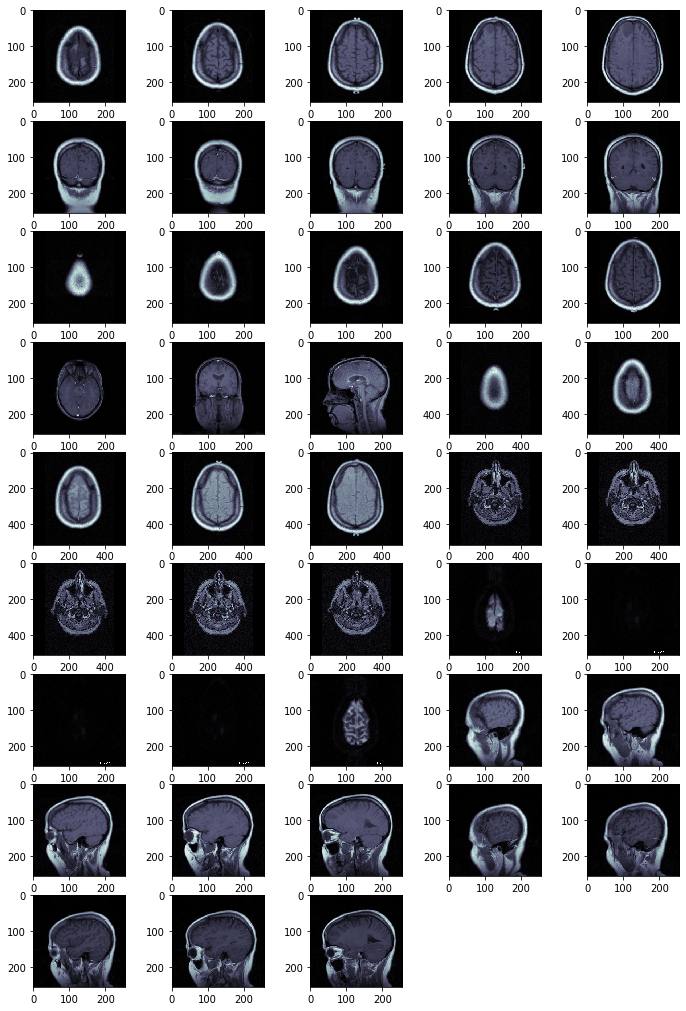

In [28]:
plt.figure(figsize=(12,20))
for i,j in enumerate(myimages):
    if i==50:
        break
    plt.subplot(10,5,i+1)
    plt.imshow(j, cmap=plt.cm.bone)

# Image Processing and conversion

# Split the images into train, validation and test sets

# Apply a random forest tree on the images to predict the vital status using scikit learn

# Apply a CNN using pytorch